In [1]:
import colorsys
import json
import numpy as np

In [2]:
n_colors = '216c'

properties_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2'
properties_path = f'{properties_dir}/properties-{n_colors}.json'

with open(properties_path) as fp:
    properties = json.load(fp)
    named_colors = properties['colors']

In [3]:
color_names = list(named_colors.keys())
raw_color_values = [named_colors[cn] for cn in color_names]

In [4]:
rgb_color_values = np.array(raw_color_values) / 255

hls_color_values = np.array([colorsys.rgb_to_hls(*c) for c in raw_color_values])
hls_max_min = (hls_color_values.max(0) - hls_color_values.min(0))
hls_min = hls_color_values.min(0)
hls_color_values = (hls_color_values - hls_min) / hls_max_min

hsv_color_values = np.array([colorsys.rgb_to_hsv(*c) for c in raw_color_values])
hsv_max_min = (hsv_color_values.max(0) - hsv_color_values.min(0))
hsv_min = hsv_color_values.min(0)
hsv_color_values = (hsv_color_values - hsv_min) / hsv_max_min

color_values_by_repr = {
    'rgb': rgb_color_values,
    'hls': hls_color_values,
    'hsv': hsv_color_values,
}

raw_color_values = np.array(raw_color_values)

In [5]:
rgb_color_values.shape, hls_color_values.shape, hsv_color_values.shape

((216, 3), (216, 3), (216, 3))

In [6]:
num_clusters = 8
balanced = True
representation = 'hls'

color_values = color_values_by_repr[representation]

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def balanced_k_means(X, n_clusters, max_iter=100, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    size_per_cluster = n_samples // n_clusters

    # Initialize centroids by randomly selecting k unique points
    initial_indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[initial_indices]

    for iteration in range(max_iter):
        # Assign each sample to the nearest centroid
        labels, _ = pairwise_distances_argmin_min(X, centroids)
        
        # Create clusters ensuring balance
        clusters = [[] for _ in range(n_clusters)]
        for idx, label in enumerate(labels):
            clusters[label].append(idx)
        
        # Balance clusters by redistributing samples if necessary
        for cluster in clusters:
            while len(cluster) > size_per_cluster+1:
                for target_cluster in clusters:
                    if len(target_cluster) < size_per_cluster:
                        target_cluster.append(cluster.pop())
                        if len(cluster) == size_per_cluster or len(cluster) == (size_per_cluster+1):
                            break
                if len(cluster) == size_per_cluster or len(cluster) == (size_per_cluster+1):
                    break
        
        # Calculate new centroids
        new_centroids = np.array([X[cluster].mean(axis=0) for cluster in clusters])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    assignation = np.zeros(len(X), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        assignation[cluster] = cluster_idx
    return assignation, centroids

def k_means(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    y = kmeans.fit_predict(X)
    cluster_centers = kmeans.cluster_centers_
    return y, cluster_centers


if balanced:
    color_assign, cluster_centers = balanced_k_means(color_values, n_clusters=num_clusters, max_iter=100)
else:
    color_assign, cluster_centers = k_means(color_values, n_clusters=num_clusters)

In [8]:
centroid_closest_colors, _ = pairwise_distances_argmin_min(cluster_centers, color_values)

centroid_color_names = [color_names[cidx] for cidx in centroid_closest_colors]

color_translation = {}
for cname, cluster in zip(color_names, color_assign.tolist()):
    color_translation[cname] = centroid_color_names[cluster]

In [9]:
# cluster_centers, color_values[centroid_closest_colors]

In [10]:
centroid_color_names

['#99cc33',
 '#cccc99',
 '#009999',
 '#9900cc',
 '#6633cc',
 '#6666cc',
 '#cc9900',
 '#33cc99']

In [11]:
color_translation

{'#000000': '#cccc99',
 '#000033': '#009999',
 '#000066': '#009999',
 '#000099': '#9900cc',
 '#0000cc': '#9900cc',
 '#0000ff': '#9900cc',
 '#003300': '#009999',
 '#003333': '#009999',
 '#003366': '#009999',
 '#003399': '#009999',
 '#0033cc': '#009999',
 '#0033ff': '#9900cc',
 '#006600': '#009999',
 '#006633': '#009999',
 '#006666': '#009999',
 '#006699': '#009999',
 '#0066cc': '#009999',
 '#0066ff': '#009999',
 '#009900': '#009999',
 '#009933': '#009999',
 '#009966': '#009999',
 '#009999': '#009999',
 '#0099cc': '#009999',
 '#0099ff': '#009999',
 '#00cc00': '#009999',
 '#00cc33': '#009999',
 '#00cc66': '#009999',
 '#00cc99': '#009999',
 '#00cccc': '#009999',
 '#00ccff': '#009999',
 '#00ff00': '#009999',
 '#00ff33': '#009999',
 '#00ff66': '#009999',
 '#00ff99': '#33cc99',
 '#00ffcc': '#6633cc',
 '#00ffff': '#99cc33',
 '#330000': '#cc9900',
 '#330033': '#9900cc',
 '#330066': '#9900cc',
 '#330099': '#9900cc',
 '#3300cc': '#9900cc',
 '#3300ff': '#9900cc',
 '#333300': '#cc9900',
 '#333333':

In [12]:
# with open(f'data/color_translation_{representation}_169b_to_{num_clusters}.json', 'w') as fp:
#     json.dump(color_translation, fp)

In [13]:
import math
import matplotlib.pyplot as plt

def display_colors(color_array, patches_per_row=10, patch_size=1):
    """
    Display a list of colors using matplotlib in multiple rows and larger patches.
    
    Parameters:
    color_array (numpy.ndarray): A 2D NumPy array with shape (n, 3), where each row represents an RGB color.
    patches_per_row (int): The number of color patches per row.
    patch_size (int or float): The size of each color patch.
    """
    num_colors = color_array.shape[0]
    num_rows = math.ceil(num_colors / patches_per_row)
    
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(patches_per_row * patch_size, num_rows * patch_size))
    
    # Create a patch for each color
    for idx, color in enumerate(color_array):
        # Normalize the RGB values to the range [0, 1]
        normalized_color = color / 255.0
        row = idx // patches_per_row
        col = idx % patches_per_row
        ax.add_patch(
            plt.Rectangle(
                (col * patch_size, row * patch_size), patch_size, patch_size, color=normalized_color))
    
    # Set the limits and hide the axes
    ax.set_xlim(0, patches_per_row * patch_size)
    ax.set_ylim(0, num_rows * patch_size)
    ax.invert_yaxis()
    ax.axis('off')
    
    plt.show()

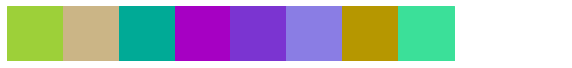

In [14]:
hls_cluster_centers = cluster_centers*hls_max_min + hls_min
hls_cluster_centers = [np.clip(colorsys.hls_to_rgb(*c),0,255) for c in hls_cluster_centers]

hsv_cluster_centers = cluster_centers*hsv_max_min + hsv_min
hsv_cluster_centers = [np.clip(colorsys.hsv_to_rgb(*c),0,255) for c in hsv_cluster_centers]

cluster_centers_rgb = {
    'rgb': cluster_centers*255,
    'hls': np.array(hls_cluster_centers),
    'hsv': np.array(hsv_cluster_centers),
}[representation] 
display_colors(cluster_centers_rgb)

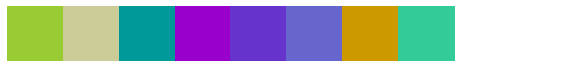

In [15]:
display_colors(np.array([named_colors[cname] for cname in centroid_color_names]))

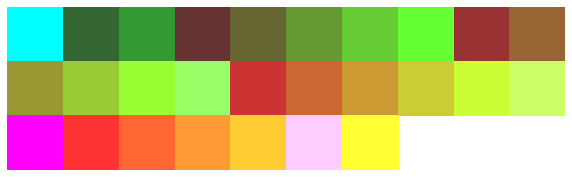

In [16]:
display_colors(raw_color_values[color_assign == 0])

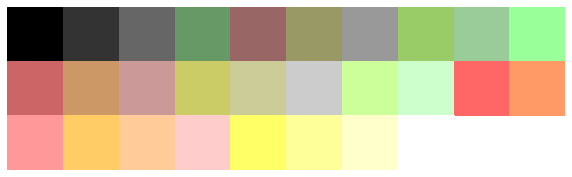

In [17]:
display_colors(raw_color_values[color_assign == 1])

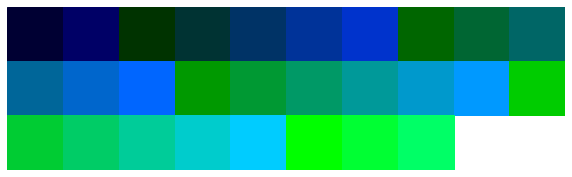

In [18]:
display_colors(raw_color_values[color_assign == 2])

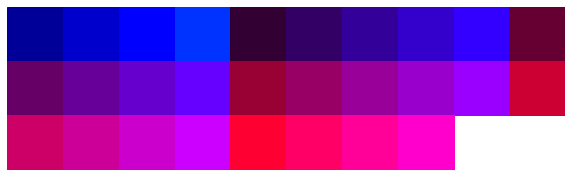

In [19]:
display_colors(raw_color_values[color_assign == 3])

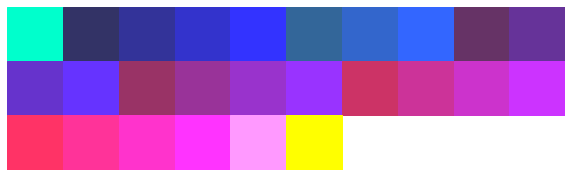

In [20]:
display_colors(raw_color_values[color_assign == 4])

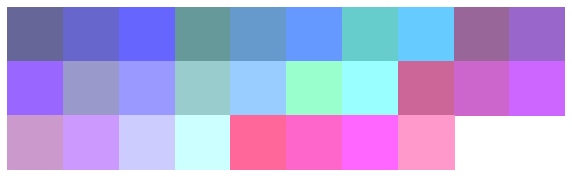

In [21]:
display_colors(raw_color_values[color_assign == 5])

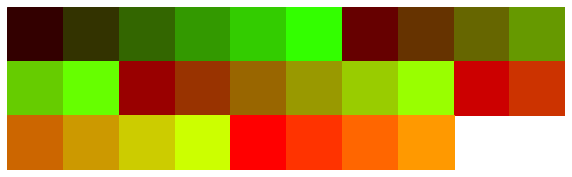

In [22]:
display_colors(raw_color_values[color_assign == 6])

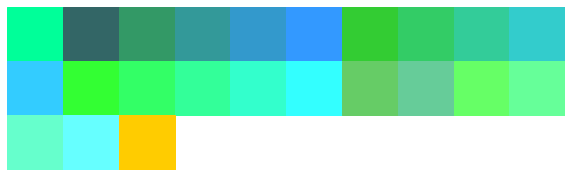

In [23]:
display_colors(raw_color_values[color_assign == 7])

In [24]:
num_clusters = 8
for rep in ['rgb','hls','hsv']:
    with open(f'data/color_translation_{rep}_169b_to_{num_clusters}.json') as fp:
        color_hash = json.load(fp)

    print([color_hash[c] for c in ["red", "green", "purple", "cyan"]])
    print([color_hash[c] for c in ["dim-grey", "blue", "brown", "yellow"]])
    print()


['sienna', 'dark-slate-gray', 'dark-orchid', 'medium-turquoise']
['light-steel-blue', 'dark-slate-gray', 'sienna', 'golden-rod']

['golden-rod', 'lime', 'dark-violet', 'lime']
['rosy-brown', 'dark-violet', 'golden-rod', 'lime']

['golden-rod', 'teal', 'teal', 'turquoise']
['dark-khaki', 'turquoise', 'golden-rod', 'golden-rod']



In [25]:
import random 

def random_copy(list_):
    shffld_list = list_.copy()
    random.shuffle(shffld_list)
    return shffld_list
    
def split_in_groups(list_, n_groups):
    groups = np.array_split(list_, n_groups)
    return [g.tolist() for g in groups]

def get_targets_of_groups(groups):
    return [random_copy(g)[0] for g in groups]

In [26]:
num_clusters = 8
n_colors = '216c'

In [27]:
if n_colors == '8':
    properties_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/'
    properties_path = f'{properties_dir}/properties.json'
else:
    properties_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2'
    properties_path = f'{properties_dir}/properties-{n_colors}.json'

with open(properties_path) as fp:
    properties = json.load(fp)
    named_colors = properties['colors']

In [28]:
color_names = list(named_colors.keys())
raw_color_values = [named_colors[cn] for cn in color_names]

In [29]:
if n_colors == '8':
    base_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/'
    B_split_path = f'{base_dir}/CoGenT_B.json'
else:
    base_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2'
    B_split_path = f'{base_dir}/CoGenT_A-{n_colors}.json'

with open(B_split_path) as fp:
    split_prop = json.load(fp)
    systematic_color_groups = [
        list(set(split_prop["sphere"]) - set(split_prop["cube"])),
        list(set(split_prop["sphere"]) - set(split_prop["cylinder"])),
    ]

In [30]:
from itertools import chain

systematic_colors = list(chain(*systematic_color_groups))
non_systematic_colors = [c for c in color_names if c not in systematic_colors]

In [31]:
len(systematic_colors), len(non_systematic_colors)

(16, 200)

In [34]:
colors_per_cluster = len(color_names) // num_clusters
print(colors_per_cluster, 'colors per cluster')

# n_systematic_clusters = len(systematic_colors)  // colors_per_cluster
# n_common_clusters = len(non_systematic_colors) // colors_per_cluster
n_systematic_clusters = max(len(systematic_colors)  // colors_per_cluster, 2)
n_common_clusters = num_clusters - n_systematic_clusters

print('n_systematic_clusters', n_systematic_clusters)
print('n_common_clusters', n_common_clusters)

27 colors per cluster
n_systematic_clusters 2
n_common_clusters 6


In [36]:
# assert colors_per_cluster <= len(systematic_colors) 

In [37]:
target_colors = []
color_groups = []

systematic_color_groups = split_in_groups(random_copy(systematic_colors), n_systematic_clusters)
target_colors.extend(get_targets_of_groups(systematic_color_groups))

common_colors_groups = split_in_groups(random_copy(non_systematic_colors), n_common_clusters)
target_colors.extend(get_targets_of_groups(common_colors_groups))

color_groups = [*systematic_color_groups, *common_colors_groups]

In [38]:
len(target_colors), num_clusters

(8, 8)

In [39]:
color_translation = {}
for tcolor, group in zip(target_colors, color_groups):
    for color in group:
        color_translation[color] = tcolor

In [48]:
from collections import Counter

Counter(color_translation.values()).most_common(), sum(y for x, y in Counter(color_translation.values()).most_common())

([('#cc33cc', 34),
  ('#cc3399', 34),
  ('#993333', 33),
  ('#006666', 33),
  ('#33cc00', 33),
  ('#66cc00', 33),
  ('#00ff00', 8),
  ('#009966', 8)],
 216)

### Check all groups have only one label

In [49]:
for g in color_groups:
    assert len(set(color_translation[c] for c in g)) == 1

### Check all colors have translation

In [50]:
def to_clean_int(input_str):
    return int(''.join(filter(str.isdigit, input_str)))

num_keys = len(set(color_translation.keys()))
num_values = len(set(color_translation.values()))

assert len(color_translation) == int(to_clean_int(n_colors))
assert set(color_translation.keys()) == set(color_names)
assert num_keys == int(to_clean_int(n_colors)), f"{num_keys} colors instead of {n_colors}"
assert num_values == num_clusters, f"{num_values} instead of {num_clusters} clusters"

for v in set(color_translation.values()):
    assert v == color_translation[v]

In [51]:
print(f'data/color_translation_random_{n_colors}_to_{num_clusters}.json')
with open(f'data/color_translation_random_{n_colors}_to_{num_clusters}.json', 'w') as fp:
    json.dump(color_translation, fp)

data/color_translation_random_216c_to_8.json


In [148]:
len(set(color_translation.values())), len(set(color_translation.keys()))

(32, 64)

In [150]:
!ls data/*c_to_*

data/color_translation_random_216c_to_108.json
data/color_translation_random_216c_to_27.json
data/color_translation_random_216c_to_54.json
data/color_translation_random_64c_to_16.json
data/color_translation_random_64c_to_32.json
data/color_translation_random_64c_to_8.json


### Get vocabulary sizes

In [2]:
from config import load_config
from data import build_datasets, CollatorForMaskedLanguageModeling, CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator

In [5]:
n_colors = '216c'
n_clusters = 27

config = load_config()
config.multimodal_pretraining = True
config.token_translation_path = f"data/color_translation_random_{n_colors}_to_{n_clusters}.json"
config.base_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}'
config.vocabulary_path = f'/workspace1/fidelrio/CLEVR_CoGenT_v1.0/colored-v2/{n_colors}/vocab.txt'

In [6]:
train_dataset, test_dataset, systematic_dataset, common_systematic_dataset = build_datasets(config)
config.pad_idx = train_dataset.pad_idx

Adapting vocab from 304 to 115


In [7]:
len(train_dataset.processor.vocabulary)

115